### create array

In [28]:
import numpy as np
import pandas as pd

# Choose frequency, binsize, longitude, latitude
freq = 'W'
binsize = 5
longitude_W = 134  # minimum is 134
longitude_E = 174  # maximum is 174
latitude_S = 10  # minimum is 10
latitude_N = 60  # minimum is 60

# load earthquake data for defined area
data = pd.read_csv('data/Japan_10_60_134_174_1973_2023_V2.csv', index_col=0)
data['Time'] = pd.to_datetime(data.Time)
data = data[(data.Longitude >= longitude_W) & (data.Longitude <= longitude_E) & (data.Latitude >= latitude_S) & (data.Latitude <= latitude_N)]
data.set_index('Time', inplace=True)
df = data.sort_index()

# Bin the longitude and latitude values into 2x2 degree bins
df['Longitude_bin'] = pd.cut(df['Longitude'], bins=np.arange(longitude_W, longitude_E + 1, binsize))  # Change bin size to 2 degrees
df['Latitude_bin'] = pd.cut(df['Latitude'], bins=np.arange(latitude_S, latitude_N + 1, binsize))  # Change bin size to 2 degrees

# Group the data by longitude bin, latitude bin, depth bin, and day, and compute the maximum magnitude within each group
grouped = df.groupby(['Longitude_bin', 'Latitude_bin', pd.Grouper(freq=freq, level="Time")]).agg({'Magnitude': 'max', 'Depth': 'mean'})
grouped = grouped.unstack().fillna(0)

# Reshape the resulting data into a tensor with shape (time, longitude, latitude, 4)
time = len(grouped.columns.levels[1])
longitude = len(grouped.index.levels[0])
latitude = len(grouped.index.levels[1])
tensor = np.zeros((time, longitude, latitude, 4))

for t in range(time):
    tensor[t, :, :, 0] = grouped['Magnitude'].iloc[:, t].values.reshape(longitude, latitude)
    tensor[t, :, :, 3] = grouped['Depth'].iloc[:, t].values.reshape(longitude, latitude)

latitude_values = np.linspace(latitude_S, latitude_N - binsize, latitude) + binsize / 2
longitude_values = np.linspace(longitude_W, longitude_E - binsize, longitude) + binsize / 2

tensor[:, :, :, 1] = np.repeat(latitude_values, longitude).reshape(latitude, longitude).T
tensor[:, :, :, 2] = np.tile(longitude_values, latitude).reshape(latitude, longitude).T

# Rotate dimensions corresponding to 20 and 25, 90 degrees anti-clockwise
tensor = np.transpose(tensor, axes=(0, 2, 1, 3))
tensor = np.flip(tensor, axis=1)

# Print the shape of the tensor
print(tensor.shape)

# Reshape tensor into matrix
matrix = np.reshape(tensor[:,:,:,0], (tensor.shape[0], -1))
# Keep only the columns with at least one number bigger than 0
matrix = matrix[:, (matrix > 0).sum(axis=0) >= 0]
print(matrix.shape)


(2609, 10, 8, 4)
(2609, 80)


### split the data

In [29]:
from sklearn.model_selection import train_test_split

# split data in train, val, test

# Activate when only forecasting one region
# matrix = np.reshape(matrix, (matrix.shape[0], matrix.shape[1], 1))

train, val_test = train_test_split(matrix, test_size=.3, shuffle=False, random_state=43)
val, test = train_test_split(val_test, test_size=.5, shuffle=False, random_state=43)

### create sliding window datasets

In [81]:
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
import tensorflow as tf

def dataset_generator(data, seq_length, samp_rate, stride, cutoff):

  input_data = data
  target_data = data
  dataset = timeseries_dataset_from_array(input_data, targets=None, sequence_length=seq_length, sampling_rate=samp_rate, sequence_stride=stride, shuffle=False, batch_size=len(data))

  return dataset

# Set lookback timewindow
lookback_window = 52 * 6
cutoff = 4.5
future_timesteps = 4
timewindow = lookback_window + future_timesteps
samp_rate = 1
stride = future_timesteps

train_dataset = dataset_generator(train, timewindow, samp_rate, stride, cutoff)
val_dataset = dataset_generator(val, timewindow, samp_rate, stride, cutoff)
test_dataset = dataset_generator(test, timewindow, samp_rate, stride, cutoff)

# Create train set
for batch in train_dataset:
    X_train = batch[:,:-future_timesteps,:]
    X_train = np.reshape(X_train, (X_train.shape[0], -1))

    y_train = batch[:,-future_timesteps:,:] >= cutoff
    y_train = np.max(y_train, axis=1).astype(int)
    # y_train = np.reshape(y_train, (y_train.shape[0], 1, y_train.shape[1])).astype(int)

# y_train = tf.reshape(y_train, shape=[y_train.shape[0], 1, y_train.shape[1]])

# Collapse the depth dimension and converts all non-zero values to 1 and zero values to 0
# y_train = tf.cast(tf.reduce_max(y_train, axis=2, keepdims=True) > 0, dtype=tf.int32)

# Create validation set
for batch in val_dataset:
    X_val = batch[:,:-future_timesteps,:]
    X_val = np.reshape(X_val, (X_val.shape[0], -1))

    y_val = batch[:,-future_timesteps:,:] >= cutoff
    y_val = np.max(y_val, axis=1).astype(int)
    # y_val = np.reshape(y_val, (y_val.shape[0], 1, y_val.shape[1])).astype(int)

# y_val = tf.reshape(y_val, shape=[y_val.shape[0], 1, y_val.shape[1]])

# Collapse the depth dimension and converts all non-zero values to 1 and zero values to 0
# y_val = tf.cast(tf.reduce_max(y_val, axis=2, keepdims=True) > 0, dtype=tf.int32)

# Create test set
for batch in test_dataset:
    X_test = batch[:,:-future_timesteps,:]
    X_test = np.reshape(X_test, (X_test.shape[0], -1))

    y_test = batch[:,-future_timesteps:,:] >= cutoff
    y_test = np.max(y_test, axis=1).astype(int)
    # y_test = np.reshape(y_test, (y_test.shape[0], 1, y_test.shape[1])).astype(int)

# y_test = tf.reshape(y_test, shape=[y_test.shape[0], 1, y_test.shape[1]])

# Collapse the depth dimension and converts all non-zero values to 1 and zero values to 0
# y_test = tf.cast(tf.reduce_max(y_test, axis=2, keepdims=True) > 0, dtype=tf.int32)

################################# Use for MLP
# Flatten 1 and 2 dimensions of X's for multivariate MLP
# X_train = np.reshape(X_train, (X_train.shape[0],-1))
# X_val = np.reshape(X_val, (X_val.shape[0],-1))
# X_test = np.reshape(X_test, (X_test.shape[0],-1))

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(365, 29120) (365, 80)
(6, 29120) (6, 80)
(7, 29120) (7, 80)


### LSTM model build

In [82]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
import keras
from keras.callbacks import EarlyStopping
from keras import regularizers

keras.backend.clear_session()

# Assuming X_train.shape is (443, 4160)
# and y_train.shape is (443, 80)

# define model
model = Sequential()

# Input layer
model.add(BatchNormalization())
model.add(Dense(64, activation='LeakyReLU', input_shape=(X_train.shape[1],),
                kernel_regularizer=regularizers.L1L2(l1=1e-4, l2=1e-4),
                bias_regularizer=regularizers.L1L2(l1=1e-4, l2=1e-4)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Hidden layer
model.add(Dense(64, activation='LeakyReLU',
                kernel_regularizer=regularizers.L1L2(l1=1e-4, l2=1e-4),
                bias_regularizer=regularizers.L1L2(l1=1e-4, l2=1e-4)))
model.add(BatchNormalization())
model.add(Dropout(0.5))


# Output layer
model.add(Dense(y_train.shape[1], activation='sigmoid'))

# Compile the model
opt = keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.BinaryFocalCrossentropy( apply_class_balancing=True, alpha=.7, gamma=1)
model.compile(optimizer=opt, loss=loss, metrics=[keras.metrics.Precision(), keras.metrics.Recall()])

# Build and display the model summary
model.build(input_shape=X_train.shape)
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (365, 29120)             116480    
 ormalization)                                                   
                                                                 
 dense (Dense)               (365, 64)                 1863744   
                                                                 
 batch_normalization_1 (Batc  (365, 64)                256       
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (365, 64)                 0         
                                                                 
 dense_1 (Dense)             (365, 64)                 4160      
                                                                 
 batch_normalization_2 (Batc  (365, 64)                2

### fit model

In [83]:
# early stopping
callback = EarlyStopping(monitor='val_loss', patience=5)
# fit model
history = model.fit(x=X_train,
                    y=y_train,
                    validation_data=(X_val,y_val),
                    batch_size=128,
                    epochs=500,
                    verbose=1,
                    callbacks=[callback],
                    shuffle=False)

Epoch 1/500
3/3 [==============================] - 1s 150ms/step - loss: 1.5140 - precision: 0.1918 - recall: 0.5091 - val_loss: 1.3794 - val_precision: 0.1649 - val_recall: 0.4742
Epoch 2/500
3/3 [==============================] - 0s 28ms/step - loss: 1.2189 - precision: 0.2021 - recall: 0.5354 - val_loss: 1.1431 - val_precision: 0.1599 - val_recall: 0.4433
Epoch 3/500
3/3 [==============================] - 0s 27ms/step - loss: 0.9984 - precision: 0.2014 - recall: 0.5259 - val_loss: 0.9737 - val_precision: 0.1667 - val_recall: 0.4742
Epoch 4/500
3/3 [==============================] - 0s 27ms/step - loss: 0.8447 - precision: 0.2068 - recall: 0.5424 - val_loss: 0.8522 - val_precision: 0.1685 - val_recall: 0.4742
Epoch 5/500
3/3 [==============================] - 0s 42ms/step - loss: 0.7507 - precision: 0.2110 - recall: 0.5565 - val_loss: 0.7878 - val_precision: 0.1679 - val_recall: 0.4742
Epoch 6/500
3/3 [==============================] - 0s 29ms/step - loss: 0.7059 - precision: 0.2161 

### predict

In [84]:
y_pred = model.predict(X_val)

1/1 [==============================] - 0s 46ms/step


### evaluation metrics

In [85]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(np.array(y_val).flatten(), y_pred.flatten() >= .5)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(np.array(y_val).flatten(), y_pred.flatten() >= .5)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(np.array(y_val).flatten(), y_pred.flatten() >= .5)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(np.array(y_val).flatten(), y_pred.flatten() >= .5)
print('F1 score: %f' % f1)

class_names = ['M<4.5', 'M>=4.5']

print(classification_report(np.array(y_val).flatten(), y_pred.flatten() >= .5, target_names=class_names))

# Calculate the proportion of the majority per row, column combination over all batches
majority_prop = np.mean(val >= cutoff, axis=0)[:]

# Calculate the complement for values lower than 0.5
majority_prop = np.where(majority_prop < 0.5, 1 - majority_prop, majority_prop)
zeroR = majority_prop.mean()

print("zeroR:", round(zeroR,4))

Accuracy: 0.902083
Precision: 0.708333
Recall: 0.876289
F1 score: 0.783410
              precision    recall  f1-score   support

       M<4.5       0.97      0.91      0.94       383
      M>=4.5       0.71      0.88      0.78        97

    accuracy                           0.90       480
   macro avg       0.84      0.89      0.86       480
weighted avg       0.91      0.90      0.91       480

zeroR: 0.9127


### confusion matrix

[Text(0, 0.5, 'M<4.5'), Text(0, 1.5, 'M>=4.5')]

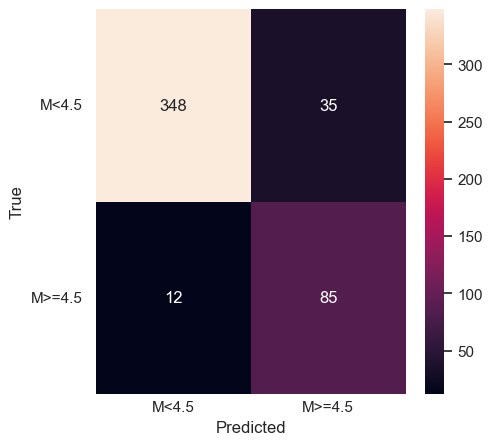

In [86]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
sns.set(rc={'figure.figsize':(5,5)})
p = sns.heatmap(confusion_matrix(np.array(y_val).flatten(), y_pred.flatten() >= 0.5), annot=True, fmt='g')
p.set_xlabel("Predicted")
p.set_ylabel("True")
p.xaxis.set_ticklabels(['M<4.5', 'M>=4.5'], ha="center", va="center")
p.yaxis.set_ticklabels(['M<4.5', 'M>=4.5'], rotation=0, va="center")